# Analyze differences in poly(A) tail lengths on gene-to-gene basis

In [1]:
###Load Packages

#Functions for polyA specific analysis (must be in same path)
from polyA_utils import *

#Packages for general column manipulation and statistics
import numpy as np
import pandas as pd
import csv
from tqdm import tqdm
from scipy import stats
import scipy.stats as sci
import pysam

#Packages for plotting
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
#Color palette for plots
four_palette = ["darkgreen", "tomato", "steelblue", "orange"]
two_palette = ["steelblue", "orange"]

Question: Are there gene-specific patterns of hyperadenylation in 4SA mutants or is the observed longer tailing global across the transcriptome? 

To do this, I will use tail metrics calculated per gene in the Snakemake pipeline as well as recalculate differences for direct comparison between two samples. 

In [3]:
#path to the data
path = "/Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/"

In [4]:
figpath = "/Users/jacksongordon/Desktop/Papers/Yale_graduate/2023_PABPN1_manuscript/November_2023_edit/plots/"

In [5]:
#Function to read polyA tab del files
def read_polyA_reads(file, min_read_count, sample_name, replicate):
    df = pd.read_csv(file, delimiter='\t')
    df = df.loc[df['tail_len'] >= min_read_count]
    df['Sample'] = sample_name
    df['Replicate'] = replicate
    return(df)

In [6]:
#Read in dfs for all reads
min_A_count = 10

h112_1 = read_polyA_reads(path + 'results/polyA_len/h112.R1_polyA.txt', min_A_count, "EV", "1")
h112_2 = read_polyA_reads(path + 'results/polyA_len/h112.R2_polyA.txt', min_A_count, "EV", "2")

h113_1 = read_polyA_reads(path + 'results/polyA_len/h113.R1_polyA.txt', min_A_count, "WT", "1")
h113_2 = read_polyA_reads(path + 'results/polyA_len/h113.R2_polyA.txt', min_A_count, "WT", "2")

h115_1 = read_polyA_reads(path + 'results/polyA_len/h115.R1_polyA.txt', min_A_count, "4SA", "1")
h115_2 = read_polyA_reads(path + 'results/polyA_len/h115.R2_polyA.txt', min_A_count, "4SA", "2")

h117_1 = read_polyA_reads(path + 'results/polyA_len/h117.R1_polyA.txt', min_A_count, "4SD", "1")
h117_2 = read_polyA_reads(path + 'results/polyA_len/h117.R2_polyA.txt', min_A_count, "4SD", "2")

#Path to gene types df (from gtf)
gene_types = pd.read_csv(path + "config/gene_types_df.tsv", sep = "\t")

#Combine replicates and intersect with gene names
all_reads = pd.concat([h112_1, h112_2, h113_1, h113_2, h115_1, h115_2, h117_1, h117_2], ignore_index = True)
all_reads["gene_id"] = all_reads["gene_id"].str.split(".").str[0]
all_reads = all_reads.merge(gene_types, on = 'gene_id')

In [7]:
#Function to read polyA tab del files AFTER running get_tails.py
def read_polyA_gene(file, sample_name, replicate):
    df = pd.read_csv(file, delimiter='\t')
    df['Sample'] = sample_name
    df['Replicate'] = replicate
    return(df)

In [8]:
#Read in dfs for gene tail metrics
per_gene_h112_1 = read_polyA_gene(path + "results/polyA_len/per_gene/h112.R1_per_gene.tsv", "EV", "1")
per_gene_h112_2 = read_polyA_gene(path + "results/polyA_len/per_gene/h112.R2_per_gene.tsv", "EV", "2")

per_gene_h113_1 = read_polyA_gene(path + "results/polyA_len/per_gene/h113.R1_per_gene.tsv", "WT", "1")
per_gene_h113_2 = read_polyA_gene(path + "results/polyA_len/per_gene/h113.R2_per_gene.tsv", "WT", "2")

per_gene_h115_1 = read_polyA_gene(path + "results/polyA_len/per_gene/h115.R1_per_gene.tsv", "4SA", "1")
per_gene_h115_2 = read_polyA_gene(path + "results/polyA_len/per_gene/h115.R2_per_gene.tsv", "4SA", "2")

per_gene_h117_1 = read_polyA_gene(path + "results/polyA_len/per_gene/h117.R1_per_gene.tsv", "4SD", "1")
per_gene_h117_2 = read_polyA_gene(path + "results/polyA_len/per_gene/h117.R2_per_gene.tsv", "4SD", "2")

#Concatenate samples and conditions into single dataframes
df_gene = pd.concat([per_gene_h112_1, per_gene_h112_2, per_gene_h113_1, per_gene_h113_2, per_gene_h115_1, per_gene_h115_2, per_gene_h117_1, per_gene_h117_2])

df_gene = df_gene.loc[df_gene['median'] >= 10]
df_gene.rename(columns={"Unnamed: 0":'gene_id'}, inplace=True)

df_gene.gene_id = df_gene.gene_id.str.split(".").str[0]
#Path to gene types df (from gtf)
gene_types = pd.read_csv("/Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/config/gene_types_df.tsv", sep = "\t")

#Combine replicates and intersect with gene names
df_gene = df_gene.merge(gene_types, on = 'gene_id')

Take a look at the distribution of tail lengths per gene using a histogram - subset by lower 25%, median, and upper 25%

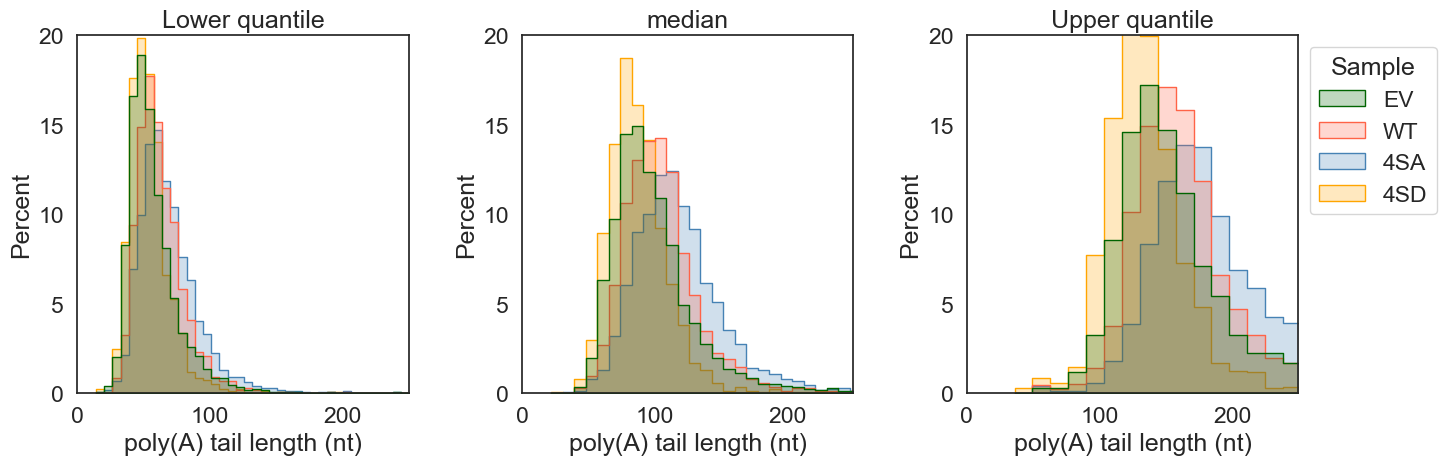

In [9]:
#Compare tail length distributions across conditions - MEDIAN
plot_samps = ["EV", "WT", "4SA", "4SD"]
plot_df = df_gene.loc[df_gene['Sample'].isin(plot_samps)]

fig, (ax1) = plt.subplots(1,3, figsize = (15, 5))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

#plot
#Lower quantile (25 percent)
sns.histplot(data=plot_df, x="quantile_25", hue="Sample", 
             palette = four_palette, ax = ax1[0], stat = 'percent', bins = 50, 
             element="step", common_norm = False, fill = True, legend = None, hue_order = plot_samps).set(title = 'Lower quantile')

#Median
sns.histplot(data=plot_df, x="median", hue="Sample", 
             palette = four_palette, ax = ax1[1], stat = 'percent', bins = 50, 
             element="step", common_norm = False, fill = True, legend = None, hue_order = plot_samps).set(title = 'median')

#Upper quantile (75 percent)
sns.histplot(data=plot_df, x="quantile_75", hue="Sample", 
             palette = four_palette, ax = ax1[2], stat = 'percent', bins = 50, 
             element="step", common_norm = False, fill = True, hue_order = plot_samps).set(title = 'Upper quantile')

sns.move_legend(ax1[2], "upper left", bbox_to_anchor=(1, 1))

ax1[0].set_xlim(0, 250)
ax1[1].set_xlim(0, 250)
ax1[2].set_xlim(0, 250)

ax1[0].set_xlim(0, 250)
ax1[1].set_xlim(0, 250)
ax1[2].set_xlim(0, 250)

ax1[0].set_ylim(0, 20)
ax1[1].set_ylim(0, 20)
ax1[2].set_ylim(0, 20)

ax1[0].set_xlabel("poly(A) tail length (nt)")
ax1[1].set_xlabel("poly(A) tail length (nt)")
ax1[2].set_xlabel("poly(A) tail length (nt)")

fig.tight_layout()

In [35]:
plot_df.loc[plot_df["gene_name"] == "TP53"]

,gene_id,mean,median,quantile_25,quantile_75,skew,n,Sample,Replicate,biotype,gene_name
6860,ENSG00000141510,155.423077,142.0,111.25,202.75,0.502279,26,EV,1,protein_coding,TP53


Plot the same data using a boxplot for alternate visualization

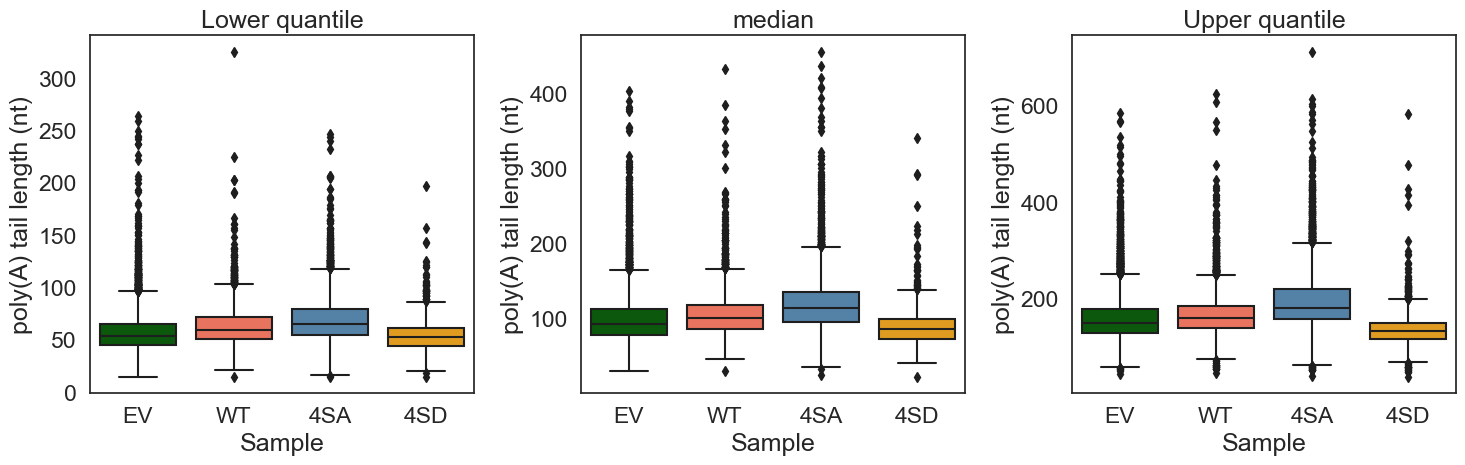

In [10]:
#Compare tail length distributions across conditions - MEDIAN
plot_samps = ["EV", "WT", "4SA", "4SD"]
plot_df = df_gene.loc[df_gene['Sample'].isin(plot_samps)]

fig, (ax1) = plt.subplots(1,3, figsize = (15, 5))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

#plot
#Lower quantile (25 percent)
sns.boxplot(data=plot_df, x="Sample", y="quantile_25", 
             palette = four_palette, ax = ax1[0], hue_order = plot_samps, order = plot_samps 
             ).set(title = 'Lower quantile')

#Median
sns.boxplot(data=plot_df, x="Sample", y="median", 
             palette = four_palette, ax = ax1[1], hue_order = plot_samps, order = plot_samps 
             ).set(title = 'median')

#Upper quantile (75 percent)
sns.boxplot(data=plot_df, x="Sample", y="quantile_75", 
             palette = four_palette, ax = ax1[2], hue_order = plot_samps, order = plot_samps 
             ).set(title = 'Upper quantile')

ax1[0].set_xlabel("Sample")
ax1[1].set_xlabel("Sample")
ax1[2].set_xlabel("Sample")

ax1[0].set_ylabel("poly(A) tail length (nt)")
ax1[1].set_ylabel("poly(A) tail length (nt)")
ax1[2].set_ylabel("poly(A) tail length (nt)")

fig.tight_layout()

plt.savefig(figpath + 'tails_per_gene_quartiles.png', dpi=300, bbox_inches="tight")

In [11]:
#Make a list of correlation dfs and calculate correlation coefficients
corr_dfs = [df_gene.loc[(df_gene.Sample == "EV") & (df_gene.Replicate == "1")].merge(df_gene.loc[(df_gene.Sample == "EV") & (df_gene.Replicate == "2")], on = "gene_id"),
            df_gene.loc[(df_gene.Sample == "WT") & (df_gene.Replicate == "1")].merge(df_gene.loc[(df_gene.Sample == "WT") & (df_gene.Replicate == "2")], on = "gene_id"),
            df_gene.loc[(df_gene.Sample == "4SA") & (df_gene.Replicate == "1")].merge(df_gene.loc[(df_gene.Sample == "4SA") & (df_gene.Replicate == "2")], on = "gene_id"),
            df_gene.loc[(df_gene.Sample == "4SD") & (df_gene.Replicate == "1")].merge(df_gene.loc[(df_gene.Sample == "4SD") & (df_gene.Replicate == "2")], on = "gene_id")]
            
corr_info = []
for i in corr_dfs:
    x = i.median_x
    y = i.median_y
    res = stats.linregress(x, y)
    corr_info.append(res)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [12]:
#Print correlation info
for i in corr_info:
    print(i.rvalue)

0.7115660770307471
0.7046512143265299
0.6705970731427375
0.7102196215018414


/var/folders/y_/x9kz6ckx4gx2pm_d26qfgy2w0000gn/T/ipykernel_20136/2495206166.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data = corr_dfs[0],
/var/folders/y_/x9kz6ckx4gx2pm_d26qfgy2w0000gn/T/ipykernel_20136/2495206166.py:15: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data = corr_dfs[1],
/var/folders/y_/x9kz6ckx4gx2pm_d26qfgy2w0000gn/T/ipykernel_20136/2495206166.py:22: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data = corr_dfs[2],
/var/folders/y_/x9kz6ckx4gx2pm_d26qfgy2w0000gn/T/ipykernel_20136/2495206166.py:29: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data = corr_dfs[3],


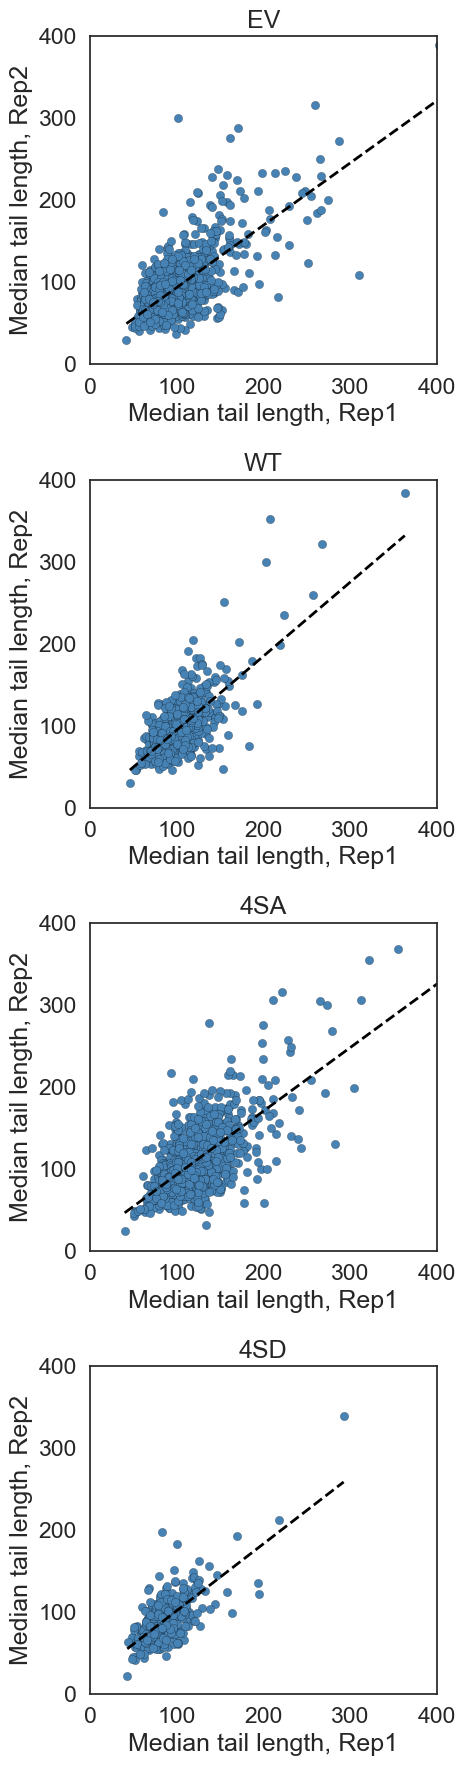

In [33]:
#Make scatterplots to look at correlation between replicates
#Compare tail length distributions across conditions - MEDIAN
fig, (ax) = plt.subplots(4,1, figsize = (5, 18))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

#plot
#EV
sns.scatterplot(data = corr_dfs[0],
            x= "median_x", y = "median_y",
             palette = four_palette, ax = ax[0], color = "steelblue", edgecolor = "black", linewidth = 0.15
             ).set(title = 'EV')
sns.lineplot(x = corr_dfs[0].median_x, y = corr_info[0].intercept + corr_info[0].slope*corr_dfs[0].median_x, color = 'black', linestyle = "--", linewidth = 2, ax = ax[0])

#WT
sns.scatterplot(data = corr_dfs[1],
            x= "median_x", y = "median_y",
             palette = four_palette, ax = ax[1], color = "steelblue", edgecolor = "black", linewidth = 0.15
             ).set(title = 'WT')
sns.lineplot(x = corr_dfs[1].median_x, y = corr_info[1].intercept + corr_info[1].slope*corr_dfs[1].median_x, color = 'black', linestyle = "--", linewidth = 2, ax = ax[1])

#4SA
sns.scatterplot(data = corr_dfs[2],
            x= "median_x", y = "median_y",
             palette = four_palette, ax = ax[2], color = "steelblue", edgecolor = "black", linewidth = 0.15
             ).set(title = '4SA')
sns.lineplot(x = corr_dfs[2].median_x, y = corr_info[2].intercept + corr_info[2].slope*corr_dfs[2].median_x, color = 'black', linestyle = "--", linewidth = 2, ax = ax[2])

#4SD
sns.scatterplot(data = corr_dfs[3],
            x= "median_x", y = "median_y",
             palette = four_palette, ax = ax[3], color = "steelblue", edgecolor = "black", linewidth = 0.15
             ).set(title = '4SD')
sns.lineplot(x = corr_dfs[3].median_x, y = corr_info[3].intercept + corr_info[3].slope*corr_dfs[3].median_x, color = 'black', linestyle = "--", linewidth = 2, ax = ax[3])

#Figure labels and limits
ax[0].set_xlim(0,400)
ax[0].set_ylim(0,400)
ax[0].set_xlabel("Median tail length, Rep1")
ax[0].set_ylabel("Median tail length, Rep2")

ax[1].set_xlim(0,400)
ax[1].set_ylim(0,400)
ax[1].set_xlabel("Median tail length, Rep1")
ax[1].set_ylabel("Median tail length, Rep2")

ax[2].set_xlim(0,400)
ax[2].set_ylim(0,400)
ax[2].set_xlabel("Median tail length, Rep1")
ax[2].set_ylabel("Median tail length, Rep2")

ax[3].set_xlim(0,400)
ax[3].set_ylim(0,400)
ax[3].set_xlabel("Median tail length, Rep1")
ax[3].set_ylabel("Median tail length, Rep2")

fig.tight_layout()

plt.savefig(figpath + 'tails_per_gene_replicate_corr.png', dpi=300, bbox_inches="tight")

For assessing whether tails are different on a per gene basis, I will look at whether each gene individually has different tail lengths between two conditions. This is more fair than asking if the number of genes with different tail lengths is significant. This is kind of like asking in a DE experiment if the number of differentially expressed genes bewtween two samples is significant. There will almost always be some - the better question is "who are they?"

In [14]:
gene_list = ["GAPDH", "HNRNPA2B1", "XIST", "ATF4", "SRSF2"]

reads_to_plot = all_reads.loc[all_reads.gene_name.isin(gene_list)]
print("p-values")
for gene in np.unique(reads_to_plot.gene_name):
    s = stats.mannwhitneyu(list(reads_to_plot.loc[(all_reads["Sample"] == "4SA") & (all_reads["gene_name"] == gene)].tail_len), 
                    list(reads_to_plot.loc[(all_reads["Sample"] == "4SD") & (all_reads["gene_name"] == gene)].tail_len), 
                    axis=0)
    print(gene + ": " + str(s.pvalue))

p-values
ATF4: 4.044502116319512e-06
GAPDH: 2.3193187576954275e-17
HNRNPA2B1: 0.0020905697783327073
SRSF2: 0.24768939126725298
XIST: 0.010747523896498056


All genes except for SRSF2 were significantly different with differing results. Now do this on a genome-wide level. 

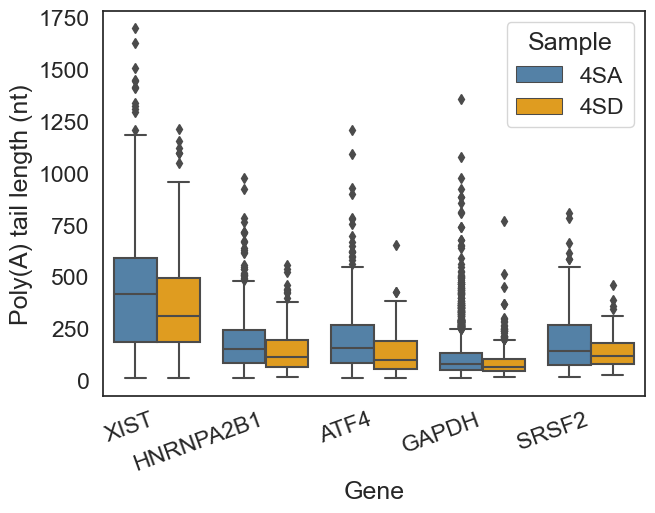

In [15]:
f, ax = plt.subplots(1,1, figsize = (7,5))

sns.boxplot(data = reads_to_plot.loc[(reads_to_plot.Sample == "4SA") |(reads_to_plot.Sample == "4SD")], x = "gene_name", y = "tail_len", palette = two_palette, hue = "Sample")


ax.set_ylabel("Poly(A) tail length (nt)")
ax.set_xlabel("Gene")
plt.xticks(rotation=20, ha='right')

plt.savefig(figpath + 'genesOfInterest_polyA_tails.png', dpi=300, bbox_inches="tight")

In [16]:
#Define a function to compare tail lengths per gene between two conditions
def compare_tail_lengths(df, c1, c2, min_reads=25):
    #select genes that are common between conditions
    c1_genes = df.loc[df.Sample == c1].gene_id
    common_genes = list(np.unique(df.loc[(df.Sample == c2) & df.gene_id.isin(c1_genes)].gene_id ))
    #calculate summary stats of each gene between conditions and test for statistical significance 
    per_gene_res_c1 = dict()
    per_gene_res_c2 = dict()
    reads_c1 = df.loc[df["Sample"] == c1]
    reads_c2 = df.loc[df["Sample"] == c2]
    for i in tqdm(np.unique(common_genes)):
        temp_c1 = reads_c1[reads_c1.gene_id == i]
        temp_c2 = reads_c2[reads_c2.gene_id == i]
        if (len(temp_c1) & len(temp_c2)) >= min_reads:
            per_gene_res_c1[i] = [np.mean(temp_c1.tail_len), np.median(temp_c1.tail_len), pearson_skew_2(temp_c1.tail_len), len(temp_c1.tail_len)]
            per_gene_res_c2[i] = [np.mean(temp_c2.tail_len), np.median(temp_c2.tail_len), pearson_skew_2(temp_c2.tail_len), len(temp_c2.tail_len), np.unique(temp_c1.gene_name)[0], stats.mannwhitneyu(temp_c1.tail_len, temp_c2.tail_len).pvalue]
    
    #build a dataframe for results output
    per_gene_c1 = pd.DataFrame.from_dict(per_gene_res_c1, orient='index', columns=[('mean' + "_" + c1), 'median'+ "_" + c1, 'skew'+ "_" + c1, 'n'+ "_" + c1])
    per_gene_c2 = pd.DataFrame.from_dict(per_gene_res_c2, orient='index', columns=[('mean' + "_" + c2), 'median'+ "_" + c2, 'skew'+ "_" + c2, 'n'+ "_" + c2, "gene_name", "pvalue"])
    per_gene_df = per_gene_c1.join(per_gene_c2)
    #correct pvalues for sample size (BH correction)
    per_gene_df["FDR"] = stats.false_discovery_control(per_gene_df["pvalue"])
    per_gene_df["log2FC"] = np.log2(per_gene_df["median_" + c2]/per_gene_df["median_" + c1])
    
    return(per_gene_df)

In [17]:
#As an initial test, compare EV to WT. 10 reads per gene required for gene consideration. 
#WARNING: this takes a while to run with a lot of genes to compare
EV_v_WT = compare_tail_lengths(all_reads, "EV", "WT", 10)

  0%|                                                                                                                                                           | 0/12443 [00:00<?, ?it/s]Fatal Python error: config_get_locale_encoding: failed to get the locale encoding: nl_langinfo(CODESET) failed
Python runtime state: preinitialized

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12443/12443 [14:05<00:00, 14.72it/s]


In [18]:
len(EV_v_WT.loc[(EV_v_WT.FDR < 0.05) & (EV_v_WT.log2FC > 0)])

270

In [19]:
#Define a pvalue and FC cut for plotting
pcut = 0.05
FC_cut = 0

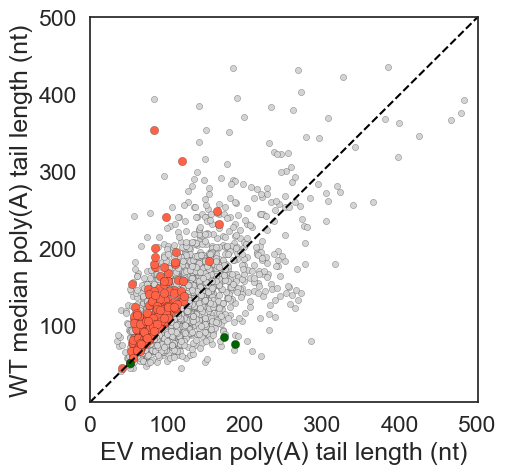

In [20]:
#EV vs WT
f, ax = plt.subplots(1,1, figsize = (5,5))

sns.scatterplot(data = EV_v_WT, x = "median_EV", y = "median_WT", s = 20, alpha = 1, color = "lightgrey", edgecolor = "black", linewidth = 0.15)
sns.scatterplot(data = EV_v_WT.loc[(EV_v_WT["log2FC"] >= FC_cut) & (EV_v_WT["FDR"] <= pcut)], x = "median_EV", y = "median_WT", color = "tomato", edgecolor = "black", linewidth = 0.15)
sns.scatterplot(data = EV_v_WT.loc[(EV_v_WT["log2FC"] <= -FC_cut) & (EV_v_WT["FDR"] <= pcut)], x = "median_EV", y = "median_WT", color = "darkgreen", edgecolor = "black", linewidth = 0.15)

sns.lineplot(x = [0,500], y = [0,500], color = "black", linestyle = "--")

ax.set_xlim(0,500)
ax.set_ylim(0,500)

ax.set_xlabel("EV median poly(A) tail length (nt)")
ax.set_ylabel("WT median poly(A) tail length (nt)")

plt.savefig(figpath + 'tailsPerGene_WTvEV.png', dpi=300, bbox_inches="tight")

Plot the data as a volcano plot for alternate visualization

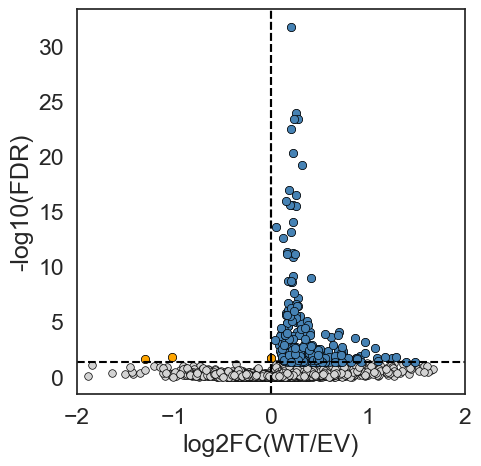

In [21]:
#EV vs WT
f, ax = plt.subplots(1,1, figsize = (5,5))

sns.scatterplot(data = EV_v_WT, x = "log2FC", y = -np.log10(EV_v_WT["FDR"]), s = 30, alpha = 1, color = "lightgrey", edgecolor = "black", linewidth = 0.5)
sns.scatterplot(data = EV_v_WT.loc[(EV_v_WT["log2FC"] >= FC_cut) & (EV_v_WT["FDR"] <= pcut)], x = "log2FC", y = -np.log10(EV_v_WT.loc[(EV_v_WT["log2FC"] >= FC_cut) & (EV_v_WT["FDR"] <= pcut)].FDR), color = "steelblue", edgecolor = "black", linewidth = 0.5)
sns.scatterplot(data = EV_v_WT.loc[(EV_v_WT["log2FC"] <= -FC_cut) & (EV_v_WT["FDR"] <= pcut)], x = "log2FC", y = -np.log10(EV_v_WT.loc[(EV_v_WT["log2FC"] <= -FC_cut) & (EV_v_WT["FDR"] <= pcut)].FDR), color = "orange", edgecolor = "black", linewidth = 0.5)

ax.set_xlim(-2,2)

ax.set_xlabel("log2FC(WT/EV)")
ax.set_ylabel("-log10(FDR)")

ax.axvline(FC_cut, color = "black", linestyle = "--")
ax.axvline(-FC_cut, color = "black", linestyle = "--")
ax.axhline(-np.log10(pcut), color = "black", linestyle = "--")

Now do this analysis with a few more comparisons: WT vs 4SA AND 4SA vs 4SD

In [22]:
#As an initial test, compare WT to 4SA. 10 reads per gene required for gene consideration. 
#WARNING: this takes a while to run with a lot of genes to compare
WT_v_4SA = compare_tail_lengths(all_reads, "WT", "4SA", 10)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12298/12298 [12:04<00:00, 16.98it/s]


In [23]:
#As an initial test, compare 4SD to 4SA. 10 reads per gene required for gene consideration. 
SA_v_SD = compare_tail_lengths(all_reads, "4SD", "4SA", 10)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10761/10761 [07:56<00:00, 22.56it/s]


In [26]:
len(SA_v_SD.loc[(SA_v_SD.FDR < 0.05) & (SA_v_SD.log2FC > 0)])

371

In [27]:
list(SA_v_SD.loc[(SA_v_SD.FDR < 0.05) & (SA_v_SD.log2FC > 0)].gene_name)

['M6PR',
 'AK2',
 'SLC25A5',
 'CCDC124',
 'PSMB1',
 'RPS20',
 'NCAPD2',
 'NME1-NME2',
 'PSMC4',
 'VIM',
 'AP3D1',
 'NDUFB4',
 'YBX1',
 'PFKP',
 'UFD1',
 'CDC42',
 'RPL31',
 'RDH11',
 'MCM2',
 'ENO1',
 'ACAT1',
 'ACTB',
 'XRCC5',
 'DDX1',
 'HSP90AA1',
 'ITGAE',
 'RPS5',
 'EIF3I',
 'CD59',
 'DNAJA1',
 'PSMC5',
 'GNAS',
 'RPL6',
 'NDUFB2',
 'HNRNPC',
 'MYL6',
 'HOOK2',
 'TMEM14A',
 'HSP90AB1',
 'ESS2',
 'SNU13',
 'POLR2F',
 'RBFOX2',
 'MYH9',
 'ST13',
 'ERH',
 'EIF5',
 'PSMB5',
 'NOP56',
 'MYL12A',
 'GLA',
 'NME4',
 'STUB1',
 'EIF3E',
 'MCM4',
 'RPS16',
 'POLR2I',
 'DMAC2',
 'RPS19',
 'RAB3D',
 'STEAP1B',
 'SSBP1',
 'CHCHD3',
 'PSMA2',
 'EDF1',
 'CUEDC2',
 'BCCIP',
 'GLRX3',
 'YWHAE',
 'RANGRF',
 'OCIAD1',
 'RPL34',
 'HSPA8',
 'RPS13',
 'ATP5B',
 'ARPC3',
 'CDK2AP1',
 'COPZ1',
 'MRPL51',
 'GAPDH',
 'TPI1',
 'AL021546.1',
 'MCM3',
 'RPS12',
 'COX7A2',
 'CCNG1',
 'C5orf15',
 'ATP6V0E1',
 'FAM162A',
 'RPL24',
 'EEF1B2',
 'RPS15',
 'COX7A2L',
 'SUMO1',
 'FARSB',
 'RPL22',
 'PARK7',
 'ATP5F1',

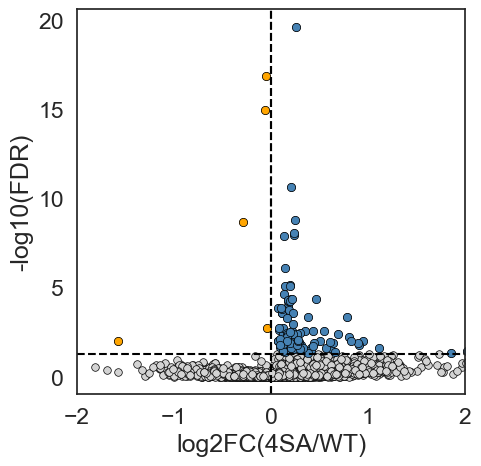

In [28]:
#WT vs 4SA
f, ax = plt.subplots(1,1, figsize = (5,5))

sns.scatterplot(data = WT_v_4SA, x = "log2FC", y = -np.log10(WT_v_4SA["FDR"]), s = 30, alpha = 1, color = "lightgrey", edgecolor = "black", linewidth = 0.5)
sns.scatterplot(data = WT_v_4SA.loc[(WT_v_4SA["log2FC"] >= FC_cut) & (WT_v_4SA["FDR"] <= pcut)], x = "log2FC", y = -np.log10(WT_v_4SA.loc[(WT_v_4SA["log2FC"] >= FC_cut) & (WT_v_4SA["FDR"] <= pcut)].FDR), color = "steelblue", edgecolor = "black", linewidth = 0.5)
sns.scatterplot(data = WT_v_4SA.loc[(WT_v_4SA["log2FC"] <= -FC_cut) & (WT_v_4SA["FDR"] <= pcut)], x = "log2FC", y = -np.log10(WT_v_4SA.loc[(WT_v_4SA["log2FC"] <= -FC_cut) & (WT_v_4SA["FDR"] <= pcut)].FDR), color = "orange", edgecolor = "black", linewidth = 0.5)

ax.set_xlim(-2,2)

ax.set_xlabel("log2FC(4SA/WT)")
ax.set_ylabel("-log10(FDR)")

ax.axvline(FC_cut, color = "black", linestyle = "--")
ax.axvline(-FC_cut, color = "black", linestyle = "--")
ax.axhline(-np.log10(pcut), color = "black", linestyle = "--")


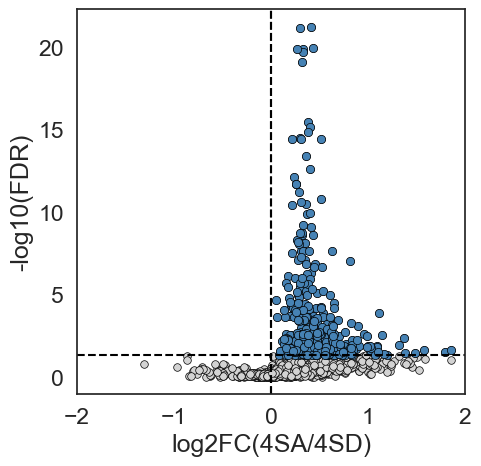

In [29]:
#GO term analysis for 4SA vs 4SD
#4SD vs 4SA
f, ax = plt.subplots(1,1, figsize = (5,5))

sns.scatterplot(data = SA_v_SD, x = "log2FC", y = -np.log10(SA_v_SD["FDR"]), s = 30, alpha = 1, color = "lightgrey", edgecolor = "black", linewidth = 0.5)
sns.scatterplot(data = SA_v_SD.loc[(SA_v_SD["log2FC"] >= FC_cut) & (SA_v_SD["FDR"] <= pcut)], x = "log2FC", y = -np.log10(SA_v_SD.loc[(SA_v_SD["log2FC"] >= FC_cut) & (SA_v_SD["FDR"] <= pcut)].FDR), color = "steelblue", edgecolor = "black", linewidth = 0.5)
sns.scatterplot(data = SA_v_SD.loc[(SA_v_SD["log2FC"] <= -FC_cut) & (SA_v_SD["FDR"] <= pcut)], x = "log2FC", y = -np.log10(SA_v_SD.loc[(SA_v_SD["log2FC"] <= -FC_cut) & (SA_v_SD["FDR"] <= pcut)].FDR), color = "orange", edgecolor = "black", linewidth = 0.5)

ax.set_xlim(-2,2)

ax.set_xlabel("log2FC(4SA/4SD)")
ax.set_ylabel("-log10(FDR)")

ax.axvline(FC_cut, color = "black", linestyle = "--")
ax.axvline(-FC_cut, color = "black", linestyle = "--")
ax.axhline(-np.log10(pcut), color = "black", linestyle = "--")

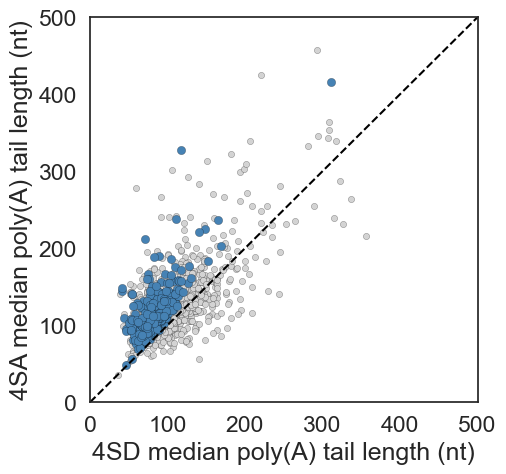

In [30]:
#4SD vs 4SD
f, ax = plt.subplots(1,1, figsize = (5,5))

sns.scatterplot(data = SA_v_SD, x = "median_4SD", y = "median_4SA", s = 20, alpha = 1, color = "lightgrey", edgecolor = "black", linewidth = 0.15)
sns.scatterplot(data = SA_v_SD.loc[(SA_v_SD["log2FC"] >= FC_cut) & (SA_v_SD["FDR"] <= pcut)], x = "median_4SD", y = "median_4SA", color = "steelblue", edgecolor = "black", linewidth = 0.15)
sns.scatterplot(data = SA_v_SD.loc[(SA_v_SD["log2FC"] <= -FC_cut) & (SA_v_SD["FDR"] <= pcut)], x = "median_4SD", y = "median_4SA", color = "orange", edgecolor = "black", linewidth = 0.15)

sns.lineplot(x = [0,500], y = [0,500], color = "black", linestyle = "--")

ax.set_xlim(0,500)
ax.set_ylim(0,500)

ax.set_xlabel("4SD median poly(A) tail length (nt)")
ax.set_ylabel("4SA median poly(A) tail length (nt)")

plt.savefig(figpath + 'tailsPerGene_4SA_4SD.png', dpi=300, bbox_inches="tight")

Clearly most genes that are significantly different between 4SA and 4SD have longer tails in 4SD (~24% of all compared genes). What happens when you compare 4SD to EV? Are there any genes where tails are shorter in 4SD? 

In [31]:
EV_v_4SD = compare_tail_lengths(all_reads, "4SD", "EV", 10)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10802/10802 [09:44<00:00, 18.47it/s]


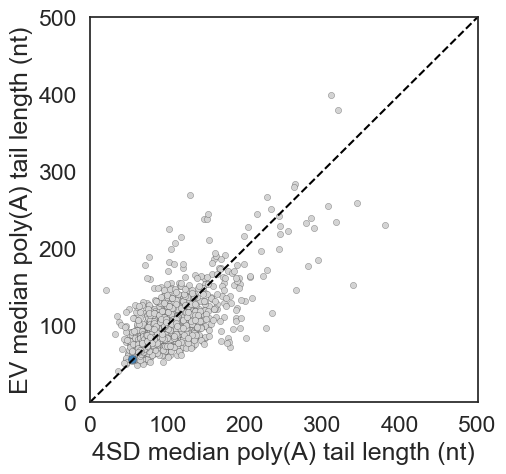

In [32]:
#4SD vs 4SD
f, ax = plt.subplots(1,1, figsize = (5,5))

sns.scatterplot(data = EV_v_4SD, x = "median_4SD", y = "median_EV", s = 20, alpha = 1, color = "lightgrey", edgecolor = "black", linewidth = 0.15)
sns.scatterplot(data = EV_v_4SD.loc[(EV_v_4SD["log2FC"] >= FC_cut) & (EV_v_4SD["FDR"] <= pcut)], x = "median_4SD", y = "median_EV", color = "steelblue", edgecolor = "black", linewidth = 0.15)
sns.scatterplot(data = EV_v_4SD.loc[(EV_v_4SD["log2FC"] <= -FC_cut) & (EV_v_4SD["FDR"] <= pcut)], x = "median_4SD", y = "median_EV", color = "orange", edgecolor = "black", linewidth = 0.15)

sns.lineplot(x = [0,500], y = [0,500], color = "black", linestyle = "--")

ax.set_xlim(0,500)
ax.set_ylim(0,500)

ax.set_xlabel("4SD median poly(A) tail length (nt)")
ax.set_ylabel("EV median poly(A) tail length (nt)")

plt.savefig(figpath + 'tailsPerGene_4SDvEV.png', dpi=300, bbox_inches="tight")

What kind of GO terms are associated with genes that are longer? 

Use PantherGO db for analysis, set reference to all genes detected in the comparison set

In [179]:
file = open('4SA_long_genes.txt','w')
for x in SA_v_SD.loc[(SA_v_SD["log2FC"] >= FC_cut) & (SA_v_SD["FDR"] <= pcut)].gene_name:
    file.write(x +"\n")
file.close()

file = open('4SA_4SD_all_genes.txt','w')
for x in SA_v_SD.gene_name:
    file.write(x +"\n")
file.close()

In [38]:
go_long_tails_bioprocess = pd.read_csv("/Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/GO/4SA_longtails_bioprocess_GO_2.txt", skiprows = 6, sep = "\t")
go_long_tails_function = pd.read_csv("/Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/GO/4SA_longtails_MolFunc_GO_2.txt", skiprows = 6, sep = "\t")
go_long_tails_component = pd.read_csv("/Users/jacksongordon/Desktop/Neugebauer_Lab/Experiments/Exp10_PABPN1_mutants_sequencing/Data_processing/Exp10/results/GO/4SA_longtails_CellComponent_GO_2.txt", skiprows = 11, sep = "\t")

go_long_tails_bioprocess["GO term"] = go_long_tails_bioprocess["GO biological process complete"].str.split("(").str[0]
go_long_tails_function['GO term'] = go_long_tails_function["GO molecular function complete"].str.split("(").str[0]
go_long_tails_component['GO term'] = go_long_tails_component["GO cellular component complete"].str.split("(").str[0]

go_long_tails_bioprocess["type"] = "bioprocess"
go_long_tails_function["type"] = "function"
go_long_tails_component["type"] = "component"

term_num = 10
go_df = pd.concat([go_long_tails_bioprocess.head(term_num).sort_values("upload_1 (fold Enrichment)", ascending = False), 
                   go_long_tails_function.head(term_num).sort_values("upload_1 (fold Enrichment)", ascending = False), 
                   go_long_tails_component.head(term_num).sort_values("upload_1 (fold Enrichment)", ascending = False)])

In [39]:
go_long_tails_function

,GO molecular function complete,Homo sapiens - REFLIST (20592),upload_1 (386),upload_1 (expected),upload_1 (over/under),upload_1 (fold Enrichment),upload_1 (raw P-value),upload_1 (FDR),GO term,type
0,ubiquitin ligase inhibitor activity (GO:1990948),9,7,0.17,+,41.49,6.710000e-09,1.700000e-06,ubiquitin ligase inhibitor activity,function
1,ubiquitin-protein transferase inhibitor activi...,10,7,0.19,+,37.34,1.120000e-08,2.580000e-06,ubiquitin-protein transferase inhibitor activity,function
2,peroxiredoxin activity (GO:0051920),8,5,0.15,+,33.34,2.340000e-06,3.290000e-04,peroxiredoxin activity,function
3,supercoiled DNA binding (GO:0097100),5,3,0.09,+,32.01,3.230000e-04,2.180000e-02,supercoiled DNA binding,function
4,TPR domain binding (GO:0030911),6,3,0.11,+,26.67,4.780000e-04,3.020000e-02,TPR domain binding,function
...,...,...,...,...,...,...,...,...,...,...
88,transmembrane signaling receptor activity (GO:...,1326,3,24.86,-,0.12,6.480000e-08,1.210000e-05,transmembrane signaling receptor activity,function
89,molecular transducer activity (GO:0060089),1549,3,29.04,-,0.10,8.810000e-10,2.780000e-07,molecular transducer activity,function
90,signaling receptor activity (GO:0038023),1549,3,29.04,-,0.10,8.810000e-10,2.620000e-07,signaling receptor activity,function
91,olfactory receptor activity (GO:0004984),431,0,8.08,-,0.01,7.430000e-04,4.220000e-02,olfactory receptor activity,function


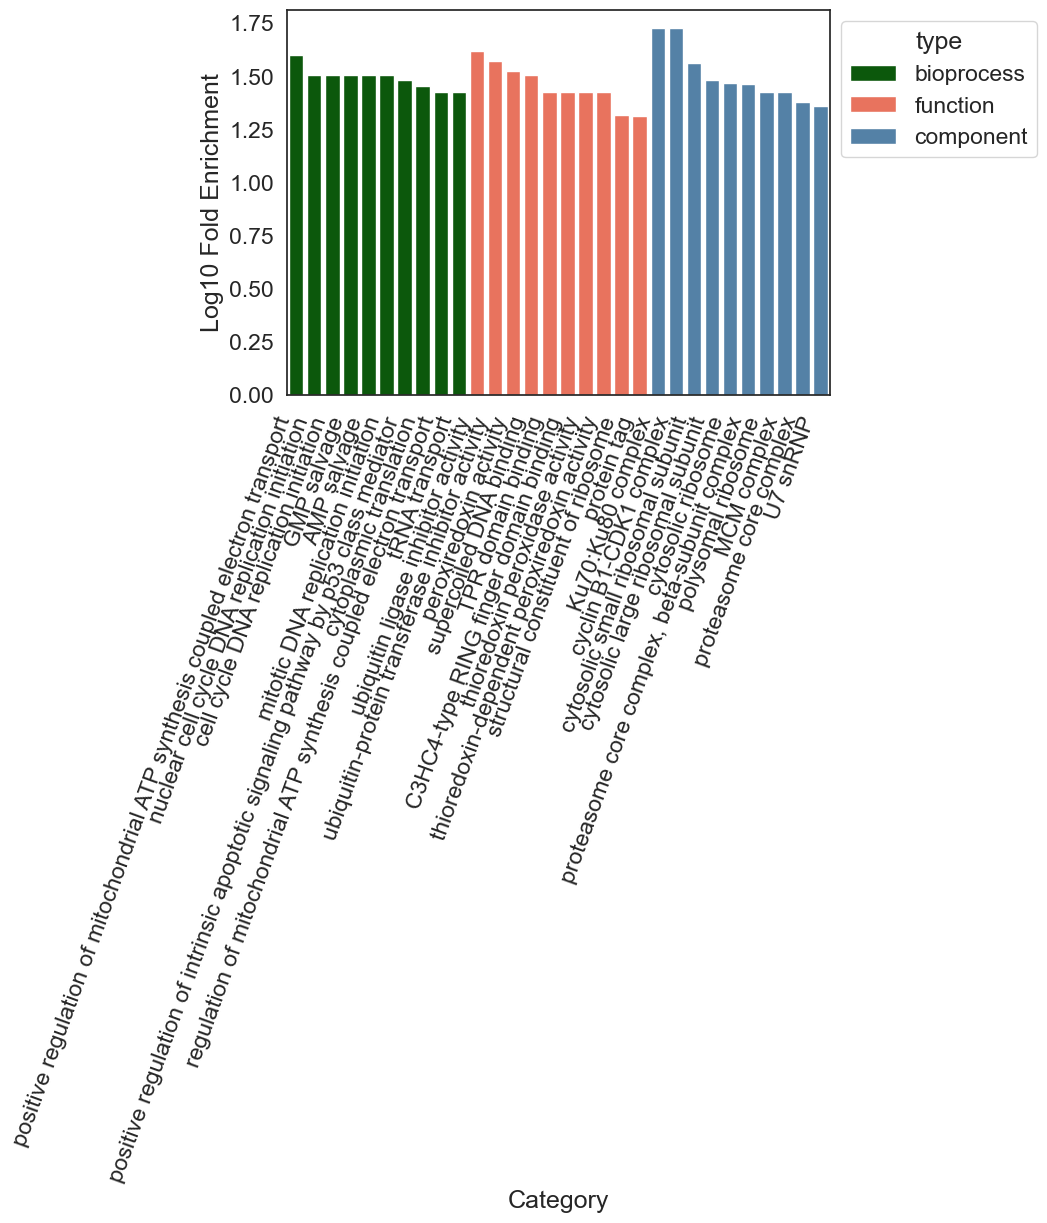

In [42]:
#Plot LogFC vs. -log10_pvalue
f, ax = plt.subplots(figsize=(7, 5))

sns.barplot(data = go_df, x = "GO term", y = np.log10(go_df["upload_1 (fold Enrichment)"]), orient = 'v', dodge = False, hue = "type", palette = four_palette)
ax.set_xlabel("Fold enrichment")
plt.xticks(rotation=70, ha='right')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
ax.set_xlabel("Category")
ax.set_ylabel("Log10 Fold Enrichment")

plt.savefig(figpath + 'longtails_GO_terms.png', dpi=300, bbox_inches="tight")

In [46]:
#Select a few genes that are significantly different
EV_v_WT.loc[EV_v_WT.FDR <= 0.05].sort_values(by = "log2FC", ascending = False).head(20)

,mean_EV,median_EV,skew_EV,n_EV,mean_WT,median_WT,skew_WT,n_WT,gene_name,pvalue,FDR,log2FC
ENSG00000126858,134.142857,83.0,1.214045,14,345.300000,354.0,-0.174800,10,RHOT1,0.003750,0.046373,2.092566
ENSG00000271270,71.000000,54.5,1.014566,10,227.000000,153.0,1.391404,11,TMCC1-AS1,0.003474,0.044589,1.489204
ENSG00000198837,177.413793,119.0,1.352184,29,337.277778,313.5,0.391125,18,DENND4B,0.003865,0.047079,1.397504
ENSG00000153044,118.520000,98.0,0.863394,25,281.090909,240.5,0.565782,22,CENPH,0.000881,0.015559,1.295183
ENSG00000113194,95.821429,84.5,0.530919,28,222.222222,200.5,0.420363,18,FAF2,0.001057,0.018104,1.246579
ENSG00000270276,103.500000,83.5,0.904837,20,206.421053,189.0,0.524987,19,HIST2H4B,0.000825,0.014990,1.178538
ENSG00000152382,98.137931,83.0,0.647291,29,183.550000,179.0,0.148816,20,TADA1,0.002977,0.040177,1.108776
ENSG00000119326,69.133333,58.0,0.791823,30,132.217391,124.0,0.338216,23,CTNNAL1,0.001122,0.018775,1.096215
ENSG00000136699,104.173077,83.5,0.759579,52,200.108108,176.0,0.581346,37,SMPD4,0.000077,0.002252,1.075727
ENSG00000120656,97.750000,75.0,0.836198,40,190.218750,147.0,1.035419,32,TAF12,0.000263,0.006363,0.970854


(-100.0, 1500.0)

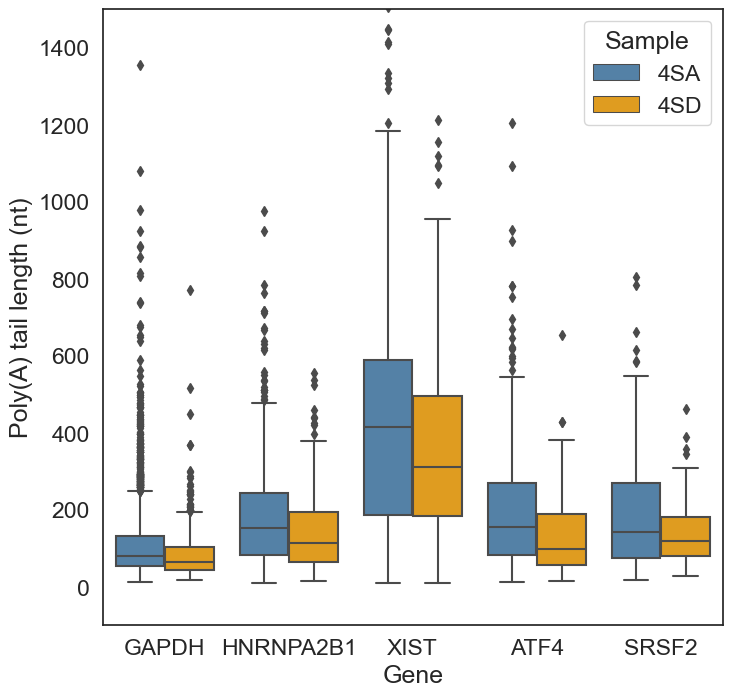

In [51]:
gene_list = ["GAPDH", "HNRNPA2B1", "XIST", "ATF4", "SRSF2"]
condition1 = "4SA"
condition2 = "4SD"
comparision = "tail_len"
Sample = "Sample"

reads_to_plot = all_reads.loc[(all_reads["gene_name"].isin(gene_list))]
reads_to_plot = reads_to_plot.loc[(reads_to_plot["Sample"] == condition1) | (reads_to_plot["Sample"] == condition2)] 

# Plot with seaborn
f, (ax) = plt.subplots(1,1, figsize = (8, 8))

sns.boxplot(data=reads_to_plot, x = "gene_name", y = "tail_len", hue = "Sample", palette = two_palette, order = gene_list)
ax.set_ylabel("Poly(A) tail length (nt)")
ax.set_xlabel("Gene")
ax.set_ylim(-100, 1500)

# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))